<SkyCoord (ICRS): (ra, dec) in deg
    (266.58818356, -28.59536026)>
(array(144.), array(136.5882353))
Noise lower: 99.00373226125897 GHz
Noise upper: 99.00678432439832 GHz
Width: 0.0030520631393500253 GHz
sigma: 0.07022012552370702 K
3 sigma: 0.21066037657112105 K


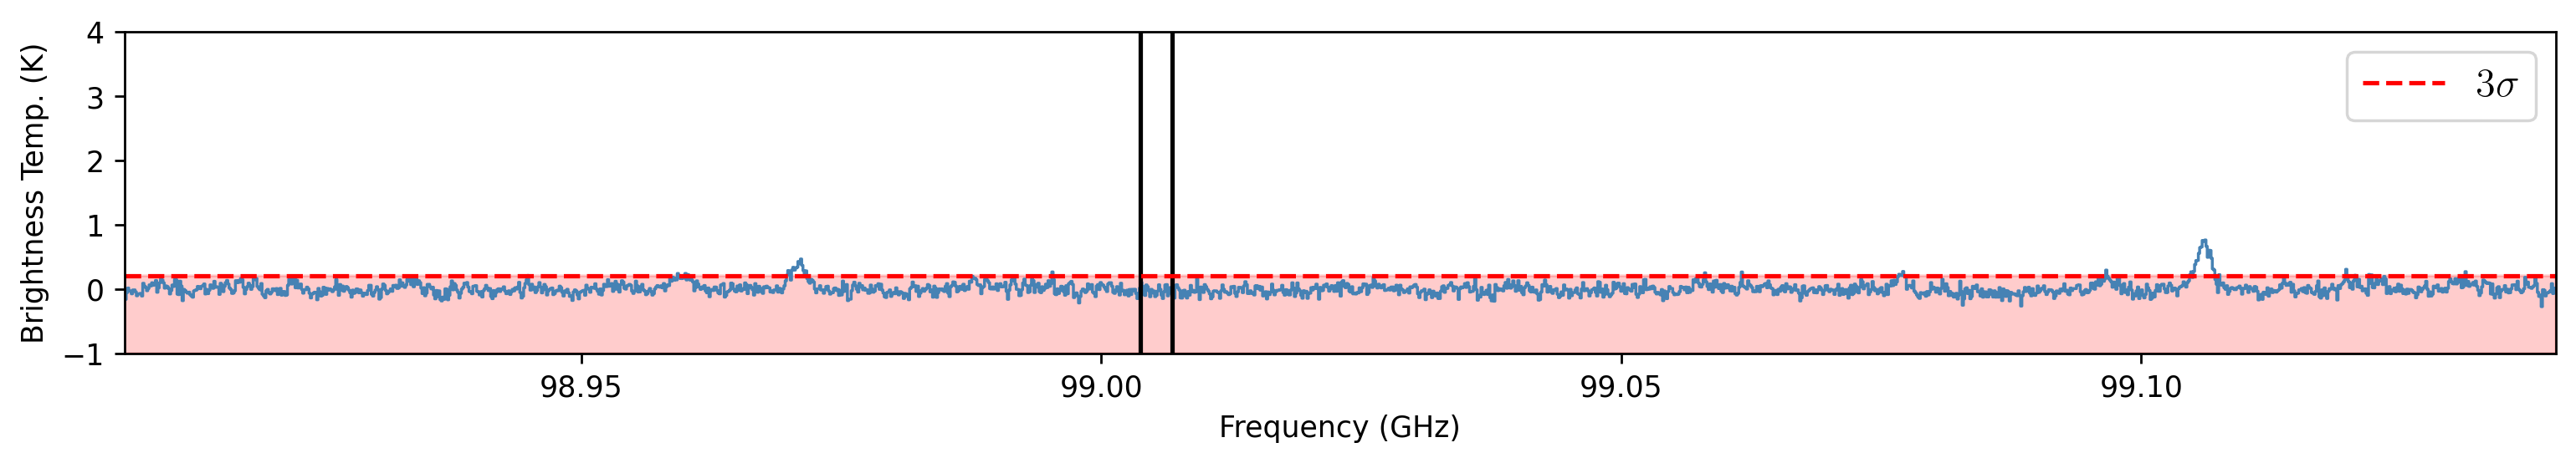

In [2]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt    
from matplotlib.patches import Rectangle
from astropy.wcs import WCS                 
from astropy import units as u  
import pylab
import numpy as np
from spectral_cube import SpectralCube
import pyspeckit
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
path="B.Dust_Ridge_sci.spw25_27_29_31.cont.I.tt0.pbcor.fits"
header=fits.getheader(path)
w1=WCS(header)
w1 = w1.dropaxis(3)
w1 = w1.dropaxis(2)

#finds the pixel positions for the RA and dec
#find RA DEC of x,y,z
core_coords=w1.pixel_to_world(175,166)
print(core_coords)
#reads in file
path="A.Dust_Ridge_sci.spw31.cube.I.pbcor.fits"
#makes figure
fig1=pylab.figure(1,figsize=(15,2),dpi=250)



#find the corresponding pixel positions for those coords in new image
header=fits.getheader(path)
w2=WCS(header)
image_coords=core_coords.to_pixel(w2,0,mode="wcs")
print(image_coords)

#plots spectrum
sc=SpectralCube.read(path)
sc.allow_huge_operations=True 
sc_Ghz=sc.with_spectral_unit(u.GHz)
sc_Ghz=sc_Ghz.to(u.K)
freq,Dec,Ra = sc_Ghz.world[:,0,0] 
subcube=sc_Ghz.hdu.data[:,int(image_coords[0])-5:int(image_coords[0])+5,int(image_coords[1])-5:int(image_coords[1])+5]
spectrum = np.average(subcube,axis=(1,2)) 
ax1=pylab.subplot()
ax1.plot(freq,spectrum,lw=1,drawstyle='steps-mid',color="SteelBlue")
pylab.xlabel("Frequency (GHz)", fontsize=10)
    
pylab.ylabel('Brightness Temp. (K)',fontsize=10)
pylab.ylim(-1,4)


plt.rcParams['text.usetex'] = True

###Noise###
Noise_upper=825
Noise_lower=800
width=freq[Noise_upper]-freq[Noise_lower]
print(f"Noise lower: {freq[Noise_lower]}")
print(f"Noise upper: {freq[Noise_upper]}")
print(f"Width: {width}")
#lower line
pylab.vlines(freq[Noise_lower].value,-1,4,colors="black")
#upper line
pylab.vlines(freq[Noise_upper].value,-1,4,colors="black")
#calculate 3 sigma
sigma=np.std(spectrum[Noise_lower:Noise_upper])
three_sigma=3*sigma
#three_sigma_Jy=three_sigma.to(u.jansky)
print(f"sigma: {sigma} K")
print(f"3 sigma: {three_sigma} K")
#print(f"3 sigma: {three_sigma_Jy} Jy")
pylab.hlines(three_sigma,freq[0].value,freq[1915].value,colors="red",label =r'$3 \sigma$',ls="--" )


pylab.xlim(freq[0].value,freq[1915].value)
ax1.fill_between(freq.value,three_sigma, -1, alpha = 0.2, color= 'red' )

#pylab.vlines(115.256,-2,7,colors="green",label=r"${}^{12}C^{16}O$",lw=2)

plt.legend(fontsize=14)
#plt.title()
plt.savefig("A.spw31.pdf")


# Line ID

Param #0   AMPLITUDE0 =     0.716654 +/-       0.0264675 
Param #1       SHIFT0 =       99.106 +/-     3.10128e-05 
Param #2       WIDTH0 =  0.000727222 +/-     3.10127e-05   Range:   [0,inf)


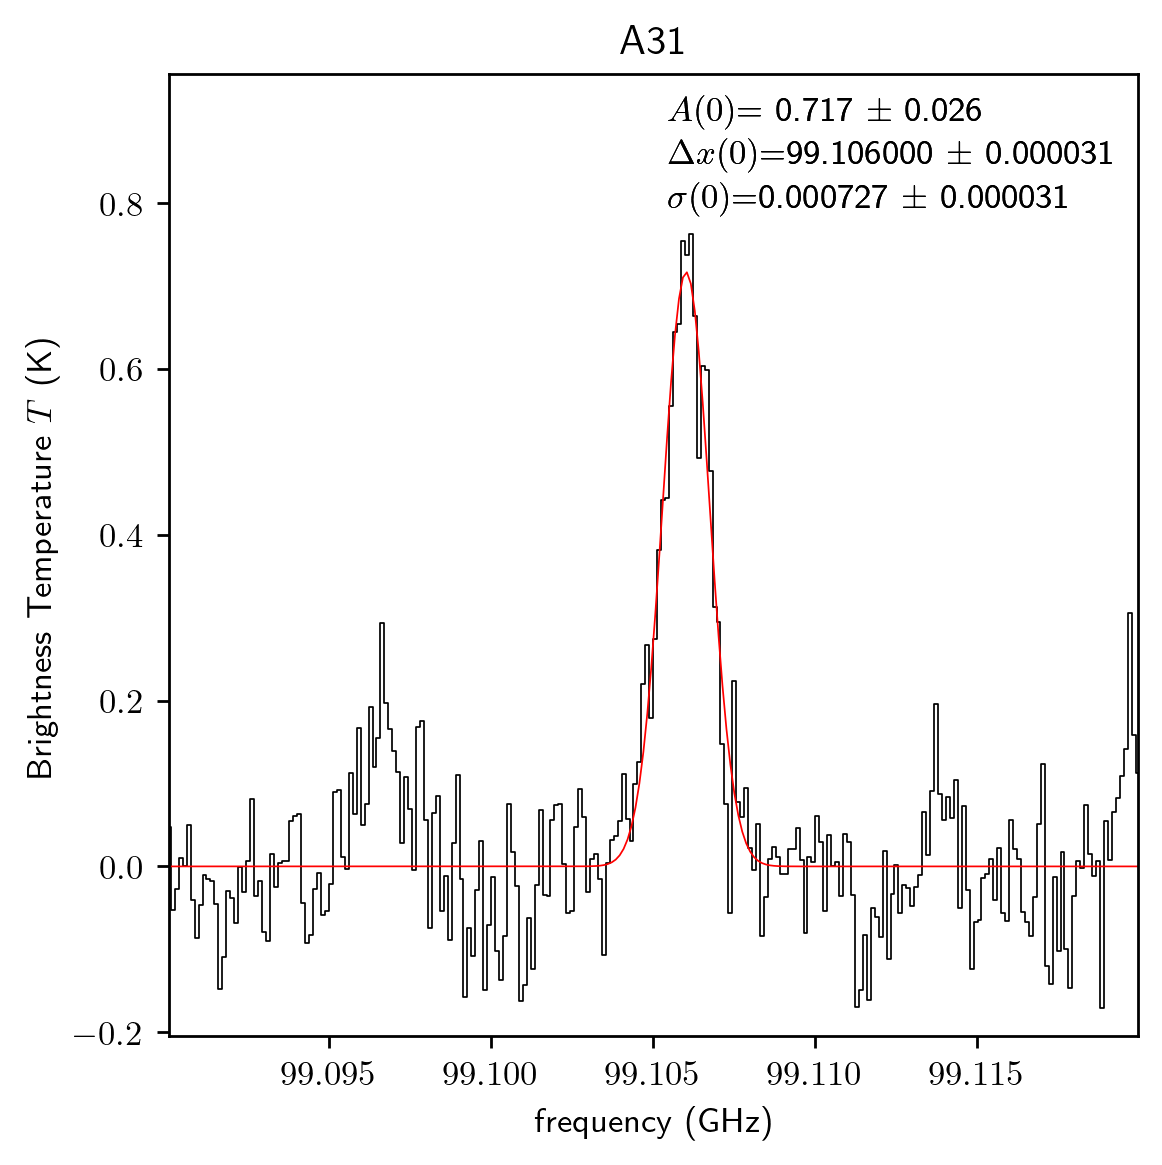

In [3]:
#Creates regions zoomed around feature
zoom = np.where((freq.value>99.09)*(freq.value<99.12))
zoom_spectrum=spectrum[zoom]
zoom_freq = freq[zoom]

#Calculates the error 
error = np.zeros(np.size(zoom))
meas = sigma #uses sigma calc from previous block
error = error + meas

#plots the gaussian fit
sp = pyspeckit.Spectrum(data=zoom_spectrum,xarr=zoom_freq,error=error,unit='K')
fig1 = pylab.figure(1,figsize=(5,5),dpi=250)
sp.plotter(axis=pylab.subplot(1,1,1),title="A31")
sp.specfit(fittype='gaussian')
sp.plotter.savefig('A.spw31.brightest.pdf')
sp.plotter.savefig('A.spw31.brightest.png')
print(sp.specfit.parinfo)